# Local SP, Global SP and xNPE demonstration on synthetic data

This is a proof-of-concept example for the Extended Neighbourhood-Proportion-Error (xNPE) implemented in ViScore.
In order to be able to visualise the types of distortions picked up by xNPE, we use simulated 2-d data as the original input, and perturbed variations of the input as the embedding to score.
We compare the xNPE empirically to the unsupervised Local SP and Global SP measures.

You can run this notebook with your ViScore conda environment.

In [147]:
import numpy as np
import pandas as pd
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ViScore

## **1.** Import simulated data

We load a synthetic dataset of points that represent distinct populations.
Each point is assigned a colour based on the population they belong to, but also using a colour gradient to visualise the internal structure of each population.
We also have 5 sets of perturbed data, simulating different types of embedding distortions with respect to the original data.

Let's first import the data.

In [136]:
## Load original simulated data, point colours and labels

points_p0 = np.load('points.npy', allow_pickle=True)
cols = np.load('cols.npy', allow_pickle=True)
labs = np.load('labs.npy', allow_pickle=True)

## Load perturbed data

points_p1 = np.load('points_p1.npy', allow_pickle=True)
points_p2 = np.load('points_p2.npy', allow_pickle=True)
points_p3 = np.load('points_p3.npy', allow_pickle=True)
points_p4 = np.load('points_p4.npy', allow_pickle=True)
points_p5 = np.load('points_p5.npy', allow_pickle=True)

Next, we plot the original data and its perturbed variants and save the plot as `'perturbations.png'` and `'perturbations.svg'`.

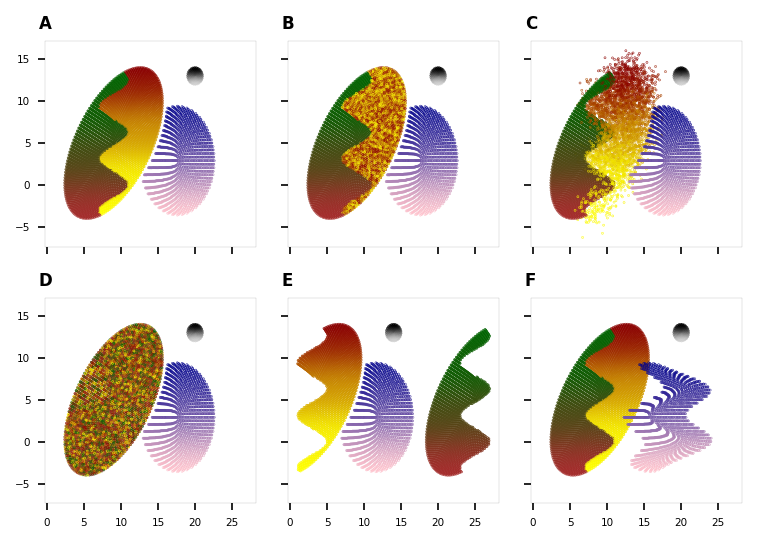

In [179]:
mpl.rcParams['axes.linewidth'] = 0.05
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(6,4), dpi=150, sharex=True, sharey=True)
fig.subplots_adjust(hspace=.25, wspace=.15)

letters = ['A', 'B', 'C', 'D', 'E', 'F']
for idx, data in enumerate([points_p0, points_p1, points_p2, points_p3, points_p4, points_p5]):
    i = idx//3
    j = np.mod(idx, 3)

    ax[i][j].tick_params(axis='both', labelsize=5)
    ax[i][j].scatter(x=data[:,0], y=data[:,1], c=cols, s=.05, marker='o')
    ax[i][j].set_title(letters[idx], size=8, fontweight='bold', ha='left', x=-.03)

fig.savefig('perturbations.png', dpi=300, transparent=True)
fig.savefig('perturbations.svg', transparent=True)

In this data, the
* *Green* population (left-most) has 4041 points
* *Yellow* population (to the right of *Green*) has 3939 points
* *Blue* population (bottom-right) has 2110 points
* *Grey* population (top-right) has 276 points

The following variants of the point cloud are shown.

* **A** is the original dataset, with correct positions of all points.
This can be considered a trivial perfect embedding of our data.
* **B** represents a distortion within a population, where point in the *Yellow* population are misembedded, but the overall position of the population with respect to the others remains intact.
* **C** represents a noisy embedding of the *Yellow* population, with Gaussian noise affecting the relative positions within it, as well as the boundaries of the population.
* **D** represents a mixing of the *Green* and *Yellow* population, which makes them indistinguishable and obscures variability in the data.
* **E** represents purely positional error, where the populations are moved into different parts of the point cloud, which mainly concerns the *Green* population and its neighbours.
* **F** represents a shape distortion in the *Purple* population that is not due to Gaussian noise and changes how it interfaces with its neighbouring *Yellow* population.

## **2.** Calculate and report Local SP, Global SP and xNPE

For each perturbation, we can now calculate how it affects the unsupervised local structure-preservation score (based on $R_{NX}$) and how it affects the xNPE (with neighbourhood size $k=50$).

In [199]:
localsp = np.round([ViScore.score(hd=points_p0, ld=pp)['Sl'] for pp in [points_p1, points_p2, points_p3, points_p4, points_p5]], 2)
globalsp = np.round([ViScore.score(hd=points_p0, ld=pp)['Sg'] for pp in [points_p1, points_p2, points_p3, points_p4, points_p5]], 2)

In [201]:
xnpe = [ViScore.xnpe(hd=points_p0, ld=pp, annot=labs, k=50) for pp in [points_p1, points_p2, points_p3, points_p4, points_p5]]

We gather the results in a dataframe, generate LaTeX code to create a nice table and save it as `'results.txt'`.

In [202]:
df = pd.DataFrame(
    data=np.array([[str(x) for x in np.round(list(x.values()), 2)] for x in xnpe]),
    columns=['Green', 'Yellow', 'Blue', 'Grey']
)
df
df.insert(loc=0, column='Perturbation', value=['B', 'C', 'D', 'E', 'F'])
df['Local'] = [str(x) for x in localsp]
df['Global'] = [str(x) for x in globalsp]
df.columns = pd.MultiIndex.from_tuples([('', 'Perturbation'), ('xNPE', 'Green'), ('xNPE', 'Yellow'), ('xNPE', 'Blue'), ('xNPE', 'Grey'), ('SP', 'Local'), ('SP', 'Global')])
df

xNPE                      SP       
  Perturbation Green Yellow  Blue Grey Local Global
0            B   0.0    0.0   0.0  0.0  0.55   0.55
1            C   0.1   0.18  0.05  0.0  0.66   0.86
2            D  0.78    0.8   0.0  0.0  0.21    0.2
3            E  0.07   0.08   0.0  0.0  0.85   0.38
4            F   0.0   0.03  0.04  0.0  0.94   0.94

In [203]:
code = df.to_latex(index=False)
code = code.replace('{lllllll}', '{r|rrrr|rr}')
code = code.replace('& \multicolumn{4}{r}{xNPE} & \multicolumn{2}{r}{SP} \\', '& \multicolumn{4}{c}{xNPE} & \multicolumn{2}{c}{SP} \\')

In [204]:
with open('results.txt', 'w') as text_file:
    text_file.write(code)

## **3.** Interpretation

The results show that xNPE only picks up on errors that distort the boundaries between populations and their relative positions.
Therefore, the shuffling of points within a population in **B** does not change xNPE values for any population.
It does, however, make the SP scores of the embedding decrease (both Local and Global, because the large *Yellow* population spans a large part of the point cloud).

Perturbation **C** increases xNPE for the *Green*, *Yellow* and *Blue* populations, due to the distortion of how they interface with each other locally.
This local distortion is also reflected in the Local SP score, however the Global score suffers less.
This is because, contrary to perturbation **B** where points were shuffled across the entire population (achieving multi-scale distortion), the Gaussian noise does not change the position of any point too drastically.

Perturbation **D** results in very high xNPE error for the *Green* and *Yellow* populations, since the boundary between them is distorted entirely.
(Recall that an xNPE value of 1 corresponds to a random embedding.)

Perturbation **E** causes some (smaller) xNPE for *Green* and *Yellow*.
This error would be larger if the populations were larger, since they would have a larger proportion of neighbours from other populations.
Local SP is somewhat harmed by the positional shift, whereas the Global SP is reduced drastically, due to the overall layout of the embedding being altered.

Perturbation **F** increases xNPE only for *Yellow* and *Blue*, since the other populations are not affected at the chosen local scale.
The effect on SP is limited.